In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_GC import CAdaptive_GC_RK4
from adaptive_GC_sqrt import CAdaptive_GC_RK4_sqrt
import matplotlib.pyplot as plt
import time

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    return linalg.funm(inv_S @ H,
                lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu)))) @ inv_S

In [4]:
def funm_herm(a, func):
    w, v = linalg.eigh(a)
    w = func(w)
    return (v * w).dot(v.conj().T)

In [5]:
def energy_error(c, mu):
    wom_E = np.trace(c.A @ c.inv_ovlp @ c.rho)
    isq = funm_herm(c.ovlp, lambda x: -1/np.sqrt(x))
    Ho = isq @ c.H @ isq
    w, v = linalg.eigh(Ho)
    
    we = [1.0/(1 + np.exp(beta*(x - mu))) for x in w]
    P = v.dot(np.diag(we)).dot(v.T)
    E = np.trace(P @ Ho)
    
    #fd_E = np.trace(c.A @ c.inv_ovlp @ fd)
    print("Band structure energy: ", wom_E, " hartree")
    print("Rel Error: ", np.abs(wom_E - E) / np.abs(E))
    print("Percentage: {:%}".format(np.abs(wom_E - E) / np.abs(E)))

In [6]:
def plot_results_fd_vs_gc(num_electrons, fd, gc):
    H = gc.H
    S = gc.ovlp
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    fignum = 1
    plt.figure(fignum)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(fd, linalg.inv(S))[::-1], 'ks-', label="Exact by FD")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(gc.rho, S)[::-1], 'r^-', 
             label="Grand Can. WOM")
    #plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/rk2_GC_pop.png", format='png', dpi=300)
    print(gc.beta)
    
    # Plot increments of dbeta that our method took
    fignum += 1
    plt.figure(fignum)
    plt.title("Variable step method in action - " + str(num_electrons) + "electrons")
    plt.plot(gc.beta_increments, '*-')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_dbeta_inc.png", format='png', dpi=300)
    
    # Plot number of electrons
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(gc.num_electron_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_num_electrons.png", format='png', dpi=300)
    
    # Plot chemical potential
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(gc.mu_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_chem_pot.png", format='png', dpi=300)

    # Check beta vs step size
    beta_vals = np.cumsum(gc.beta_increments)
    fignum += 1
    plt.figure(fignum)
    plt.plot(gc.beta_increments, beta_vals)
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_beta_vs_stepsize.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.plot(beta_vals, (gc.energy_vals - min(gc.energy_vals))[:-1])
    plt.xlabel("beta")
    plt.ylabel("E(beta) - min(E)")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_energy_vs_beta.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((gc.energy_vals - min(gc.energy_vals))[:-1])
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_energy_vs_steps.png", format='png', dpi=300)

In [7]:
# Define path for matrices
matrices_path = "larger_matrices/"

### 32 electrons

In [8]:
# Define path to H and S matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

# We need the eigenvalues and eigenvectors for H
E, V = linalg.eigh(H_16, S_16)

# Define num_electrons and beta
num_electrons = 3*16
beta = 10
dbeta = 0.13

# Define chemical potential
core_spec = linalg.eigvalsh(H_16, S_16)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [9]:
np.allclose(H_16 @ V[:, 1], E[1] * S_16 @ V[:, 1])

True

In [10]:
sqrt_gc_16 = CAdaptive_GC_RK4_sqrt(ovlp=S_16, H=H_16, 
                                   dbeta=dbeta, epsilon=1e-2, mu=mu, tol=1e-6)
sqrt_gc_16.propagate(beta, sqrt_gc_16.single_step_rk2)
ferm_exact_16 = get_exact(H_16, S_16, num_electrons, sqrt_gc_16.beta, sqrt_gc_16.mu)

funm result may be inaccurate, approximate err = 1


10.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


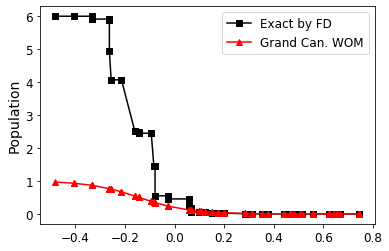

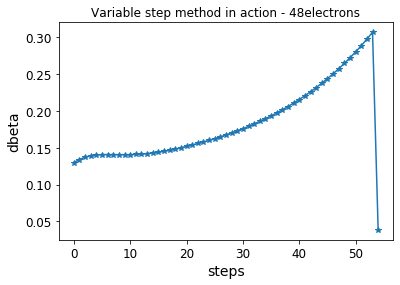

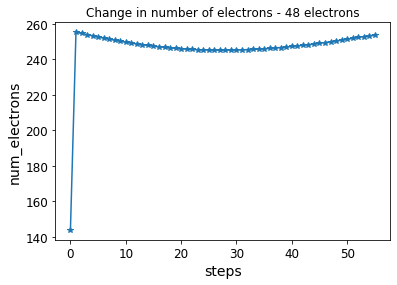

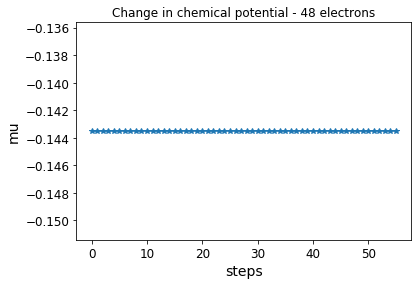

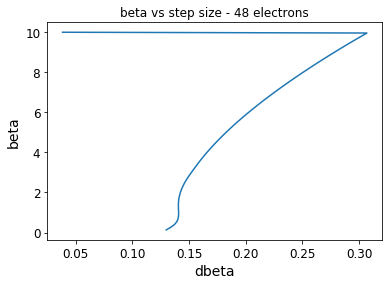

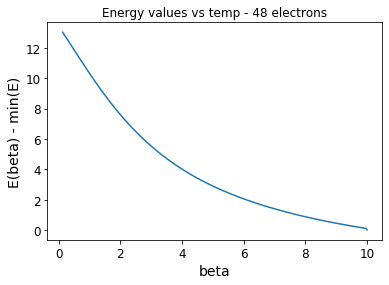

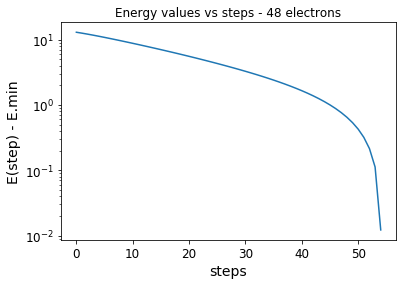

In [11]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_16, sqrt_gc_16)

In [30]:
energy_error(sqrt_gc_16, sqrt_gc_16.mu)

Band structure energy:  (-6.038608221042997+0j)  hartree
Rel Error:  2.9702356216471335e-06
Percentage: 0.000297%


### 108 electrons

In [12]:
# Define path to H and S matrices
H_54 = mmread(matrices_path + "54_H.mtx").toarray()
S_54 = mmread(matrices_path + "54_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 3*54
beta = 100
dbeta = 0.13

# Define chemical potential
core_spec = linalg.eigvalsh(H_54, S_54)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [13]:
sqrt_gc_54 = CAdaptive_GC_RK4_sqrt(ovlp=S_54, H=H_54,
                                   dbeta=dbeta, epsilon=1e-2, mu=mu, tol=1e-6)
sqrt_gc_54.propagate(beta, sqrt_gc_54.single_step_rk2)
ferm_exact_54 = get_exact(H_54, S_54, num_electrons, sqrt_gc_54.beta, sqrt_gc_54.mu)

funm result may be inaccurate, approximate err = 1


100.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


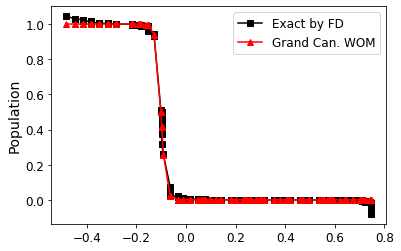

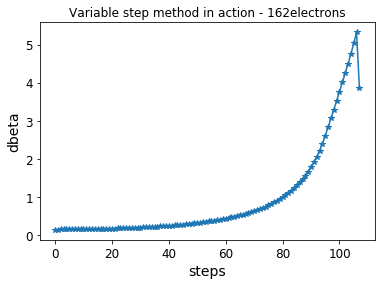

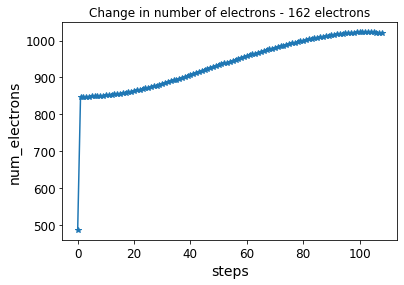

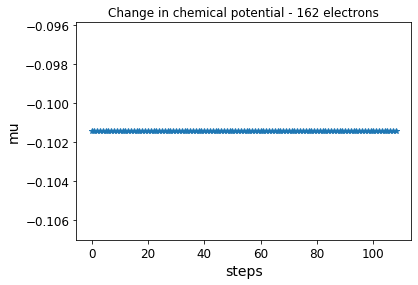

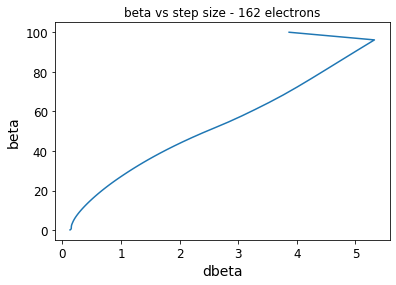

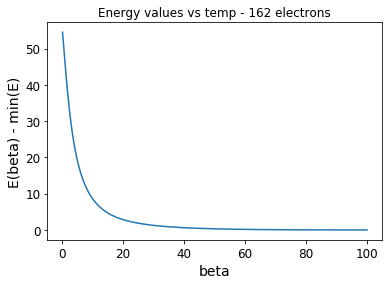

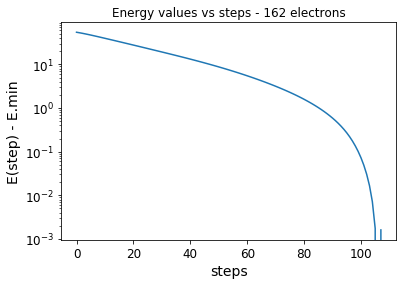

In [14]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_54, sqrt_gc_54)

In [29]:
energy_error(sqrt_gc_54, sqrt_gc_54.mu)

Band structure energy:  (-21.51982774172522-2.1666711874356403e-34j)  hartree
Rel Error:  1.817509954852807e-05
Percentage: 0.001818%


### 256 electrons

In [17]:
# Define path to H and S matrices
H_128 = mmread(matrices_path + "128_H.mtx").toarray()
S_128 = mmread(matrices_path + "128_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 3*128
beta = 100
dbeta = 0.13

# Define chemical potential
core_spec = linalg.eigvalsh(H_128, S_128)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [18]:
sqrt_gc_128 = CAdaptive_GC_RK4_sqrt(ovlp=S_128, H=H_128,
                                    dbeta=dbeta, epsilon=1e-2, mu=mu, tol=1e-6)
sqrt_gc_128.propagate(beta, sqrt_gc_128.single_step_rk2)
ferm_exact_128 = get_exact(H_128, S_128, num_electrons, sqrt_gc_128.beta, sqrt_gc_128.mu)

funm result may be inaccurate, approximate err = 1


100.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


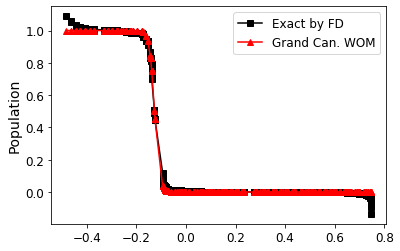

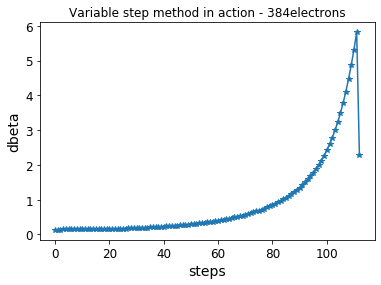

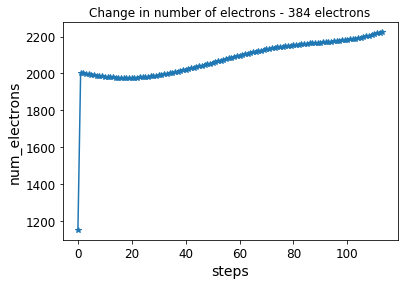

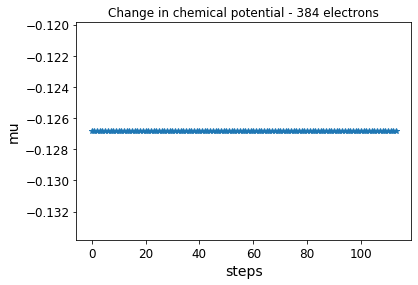

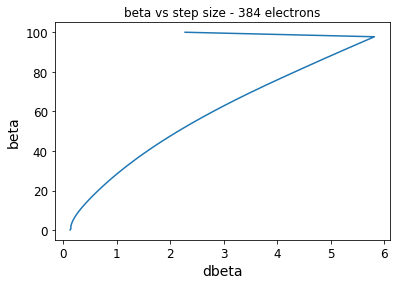

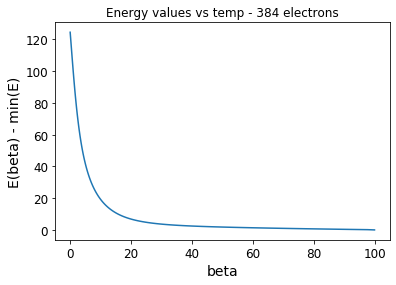

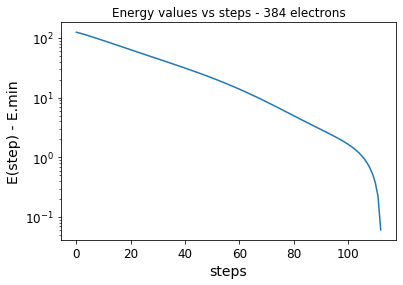

In [19]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_128, sqrt_gc_128)

In [28]:
energy_error(sqrt_gc_128, sqrt_gc_128.mu)

Band structure energy:  (-48.57628764016959-9.62964972193618e-34j)  hartree
Rel Error:  1.2303382469466763e-05
Percentage: 0.001230%


### 500 electrons

In [20]:
# Define path to H and S matrices
H_250 = mmread(matrices_path + "250_H.mtx").toarray()
S_250 = mmread(matrices_path + "250_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 3*250
beta = 100
dbeta = 0.13

# Define chemical potential
core_spec = linalg.eigvalsh(H_250, S_250)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [21]:
sqrt_gc_250 = CAdaptive_GC_RK4_sqrt(ovlp=S_250, H=H_250,
                                    dbeta=dbeta, epsilon=1e-2, mu=mu, tol=1e-6)
sqrt_gc_250.propagate(beta, sqrt_gc_250.single_step_rk2)
ferm_exact_250 = get_exact(H_250, S_250, num_electrons, sqrt_gc_250.beta, sqrt_gc_250.mu)

funm result may be inaccurate, approximate err = 1


100.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


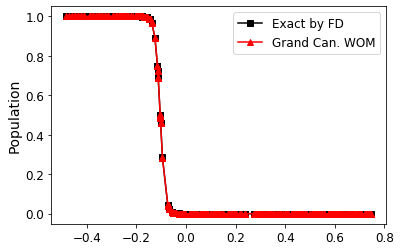

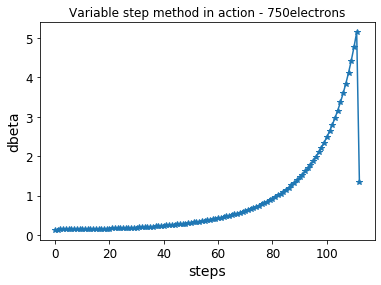

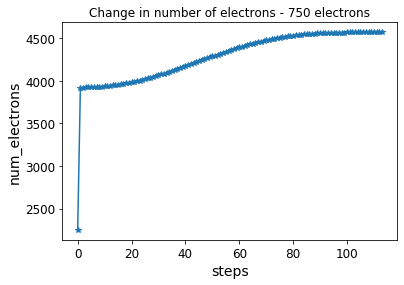

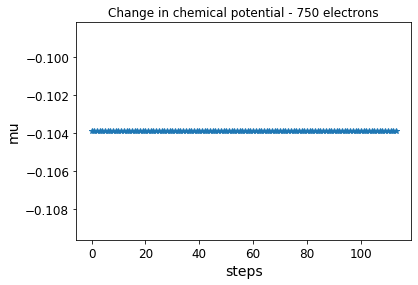

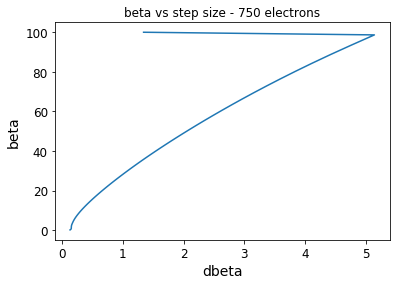

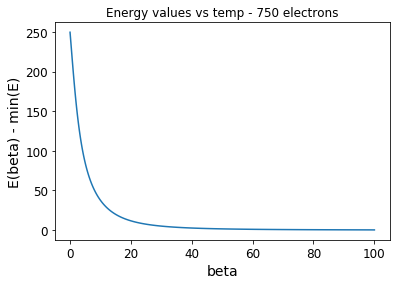

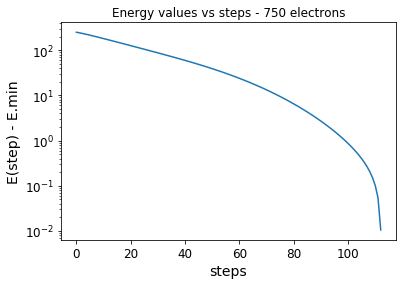

In [22]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_250, sqrt_gc_250)

In [27]:
energy_error(sqrt_gc_250, sqrt_gc_250.mu)

Band structure energy:  (-97.94218976516575+0j)  hartree
Rel Error:  1.4505171690864434e-05
Percentage: 0.001451%


### Comparison

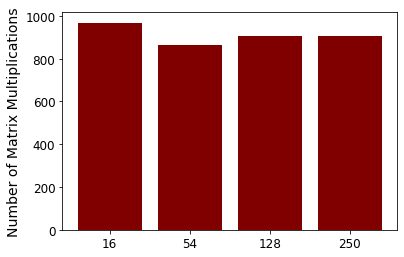

In [23]:
x = [1, 2, 3, 4]
y = [4*sqrt_gc_16.count, 4*sqrt_gc_54.count, 4*sqrt_gc_128.count, \
     4*sqrt_gc_250.count]
ax = plt.subplot()
ax.bar(x, y, color='maroon')
ax.set_ylabel("Number of Matrix Multiplications")
ax.set_xticklabels(['16', '54', '128', '250'])
ax.set_xticks(x)
#ax.set_xlabel("Num atoms")
#plt.title("GC Steps vs Num Atoms")
plt.savefig("larger_matrices/sqrt_figs/GC/gc_steps_vs_size.png", format='png', dpi=300)

In [24]:
print(sqrt_gc_16.beta_increments[0])
print(sqrt_gc_54.beta_increments[0])
print(sqrt_gc_128.beta_increments[0])
print(sqrt_gc_250.beta_increments[0])

0.13
0.13
0.13
0.13


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


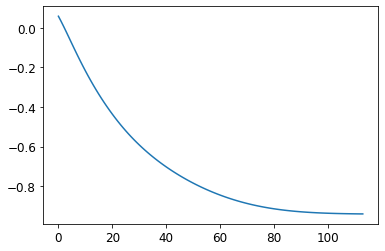

In [25]:
plt.plot(np.array(sqrt_gc_250.energy_vals) / 250)

In [26]:
print(sqrt_gc_16.beta)
print(sqrt_gc_54.beta)
print(sqrt_gc_128.beta)
print(sqrt_gc_250.beta)

100.0
100.0
100.0
100.0
